In [116]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipynb
from scipy.spatial import distance_matrix
import random
import sys as sys
import time
import re
import pickle
import math

In [3]:
from ipynb.fs.full.datamanagement import user_filter, summarise_listening_history
from ipynb.fs.full.evaluation_workflow import split_history
from ipynb.fs.full.feature_based_algos import get_listenings_history_partition, kmeans_based_ranking, rank_by_artist_filter


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, auc

from scipy.spatial import distance_matrix

## Data loading

In [4]:
# Read the data
CUR_DIR = os.path.abspath('')

DATA_DIR = Path(CUR_DIR).parent / "data"
FILE_PATH = DATA_DIR/'triplets_metadata_spotify.csv'
df = pd.read_csv(FILE_PATH, index_col = 0)

In [5]:
df['track_id'] = df.song_name + ' - ' + df.artist_name

In [6]:
len(df)

4982520

## Data management

In [7]:
## keep first occurence of a given song/artist instance to reduce redundant observations

df = df.drop_duplicates(subset = ['user','track_id'], keep='first')
len(df)

4973744

### Users filtering

In [8]:
users_summary = summarise_listening_history(df)

In [9]:
ids = user_filter(users_summary, nlist_min = 1, nlist_max = 500, ntracks_min = 5)

In [10]:
wdf = df.loc[df['user'].isin(ids),:]
wdf_users_summary = users_summary.loc[users_summary['user'].isin(ids),:]

In [11]:
print('Nb of ligns in df  :', len(df))
print('Nb of ligns in wdf :', len(wdf))

Nb of ligns in df  : 4973744
Nb of ligns in wdf : 3856377


In [11]:
len(wdf_users_summary)

327081

In [12]:
wdf_users_summary.head()

,user,listening_count,track_count
7,00007ed2509128dcdd74ea3aac2363e24e9dc06b,11,10
11,0000bb531aaa657c932988bc2f7fd7fc1b2050ec,14,10
12,0000d3c803e068cf1da17724f1674897b2dd7130,7,5
14,0000f88f8d76a238c251450913b0d070e4a77d19,30,8
15,000138e252eea35fd73aaf66a9b34102b695a9c8,26,13


### Songs management

In [13]:
# Get the songs quantitative features

tracks_feats = df.drop(['user', 'listening_count'],axis = 1)
tracks_feats['track_id'] = df.song_name + ' - ' + df.artist_name
tracks_quanti_feats = tracks_feats.drop(['song_name', 'release', 'artist_name',
        'artist_familiarity', 'artist_hotttnesss', 'year', 'key',
       'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date', 'duration', 'tempo'], axis = 1).drop_duplicates()

In [14]:
# Normalize the songs quantitative feats
X = tracks_quanti_feats.drop(['track_id'], axis = 1)
X.index = tracks_quanti_feats.track_id

scaler = StandardScaler()
X[X.columns] = pd.DataFrame(scaler.fit_transform(X), index=X.index)


In [15]:
X

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
track_id,,,,,,,,
Stronger - Kanye West,0.667073,0.244482,0.234685,0.971940,-0.825165,-0.623569,1.661334,0.055057
Stacked Actors - Foo Fighters,-0.048441,1.150060,0.862181,-0.294877,-0.842482,-0.620462,0.105924,0.728483
Clarity - John Mayer,0.868312,0.283685,1.220943,-0.411504,-0.316887,-0.526080,-0.197701,0.039664
Gimme Stitches - Foo Fighters,0.180747,1.244146,1.071496,-0.108876,-0.843348,-0.614856,0.260399,0.197438
Breakout - Foo Fighters,-0.501227,1.165741,1.072171,-0.272758,-0.848599,-0.614704,-0.480018,-0.206617
...,...,...,...,...,...,...,...,...
Dime - Jerry Rivera,0.991291,-0.429800,-0.219056,-0.392401,1.575591,-0.623569,0.015369,1.247983
The Long Conversation - Pierre de Reeder,-0.395018,-1.370660,-0.236161,-0.523105,1.705467,-0.520901,0.825034,-1.007032
That's the Way That It Was - Pierre de Reeder,0.583224,0.228801,0.703957,-0.425580,-0.754445,-0.623329,-0.543939,-0.679940


## Recommendation algorithms evaluation

In [16]:
wdf_sorted = wdf.sort_values('user')
wdf_users_summary_sorted = wdf_users_summary.sort_values('user')

In [17]:
# Set the seed
seed = 1234
random.seed(seed)

In [21]:
# # Try 1; Triplets non sorted by users, without users_summary
# st = time.time()
# test1, test2 = split_history(wdf, 0.2, sort = True, random_state = seed)
# et = time.time()
# elapsed_time = et - st
# print('Execution time 1:', elapsed_time, 'seconds')

Sorting the triplets by users id ... Done
Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...Execution time 1: 42.95786738395691 seconds


In [22]:
# # Try 2: Triplets non sorted by users, with users_summary
# st = time.time()
# test1, test2 = split_history(wdf, 0.2, sort = True, users_summary = wdf_users_summary, random_state = seed)
# et = time.time()
# elapsed_time = et - st
# print('Execution time 2:', elapsed_time, 'seconds')

Sorting the triplets by users id ... Done
Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...Execution time 2: 36.215386390686035 seconds


In [23]:
# # Try 3: Triplets sorted by users, without users_summary
# st = time.time()
# test1, test2 = split_history(wdf_sorted, 0.2, sort = False, random_state = seed)
# et = time.time()
# elapsed_time = et - st
# print('Execution time 3:', elapsed_time, 'seconds')


Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...Execution time 2: 21.979166746139526 seconds


In [18]:
# Try 4: Triplets sorted by users, without users_summary
st = time.time()
test1, test2 = split_history(wdf_sorted, 0.2, sort = False, users_summary = wdf_users_summary_sorted, random_state = seed)
et = time.time()
elapsed_time = et - st
print('\n Execution time 4:', elapsed_time, 'seconds')


Computing the number of tracks listened by the users ... Done
Defining hidden tracks ids ... Done
Defining apparent tracks ids ... Done
Splitting the listening history ...
 Execution time 4: 6.485180139541626 seconds


In [26]:
RES_FILENAME = str(seed)+'.txt'
RES_FILE = DATA_DIR/RES_FILENAME
RES_FILE


WindowsPath('C:/Users/pierr/Documents/Datascientist/reco-musicale/AVR23_BDS_reco_musicale/data/1234.txt')

In [44]:
## Initiate the dictionnary of the results

# dic_res = {
#     'data_set' : {
#         'apparent' : test1,
#         'hidden' : test2
#     },
#     'reco' : {
#         'random' : {},
#         'avg' : {},
#         'kmbr' : {},
#         'avg_af' :{},
#         'kmbr_af' : {}
#     },
#     'perf' : {
#         'random' : {
#             'tpr' : {},
#             'fpr' : {},
#         },
#         'avg' : {
#             'tpr' : {},
#             'fpr' : {},
#         },
#         'kmbr' : {
#             'tpr' : {},
#             'fpr' : {},
#         },
#         'avg_af' : {
#             'tpr' : {},
#             'fpr' : {},
#         },
#         'kmbr_af' :{
#             'tpr' : {},
#             'fpr' : {},
#         }
#     }
# }

# with open(RES_FILE, 'wb') as f:
#     pickle.dump(dic_res, f)

In [45]:
### Get the saved dictionnary of results corresponding to the seed

with open(RES_FILE, 'rb') as fp:
    dic_res = pickle.load(fp)

### Hyper-parameters tuning

In [220]:
# Define the desired sample
n_tracks_min = 101
n_tracks_max = inf

In [221]:
sample = user_filter(wdf_users_summary, ntracks_min = n_tracks_min, ntracks_max = n_tracks_max).sample(200, random_state = 1234)

In [222]:
len(sample)

200

### Get the sample

In [223]:
df_apparent_sample = test1.loc[test1.user.isin(sample),: ]
df_hidden_sample = test2.loc[test2.user.isin(sample),: ]

In [224]:
dic_hidden = { u : df_hidden_sample[['user','track_id']].loc[df_hidden_sample.user == u] for u in sample}
dic_apparent = { u : df_apparent_sample.loc[df_apparent_sample.user == u] for u in sample}

### Random recommentation

In [225]:
dic_hidden_random_ranks = {u : random.sample(list(np.arange(1,len(X)-len(dic_hidden[u]))),len(dic_hidden[u])) for u in sample}

In [226]:
### Cutoff thresholds grid
threshold_grid = np.arange(1, len(X)+9, 10)

In [227]:
rand_tpr = {u : [sum(dic_hidden_random_ranks[u] <= i)/len(dic_hidden_random_ranks[u]) for i in threshold_grid] for u in sample}

In [228]:
rand_fpr = {u : [(i-sum(dic_hidden_random_ranks[u] <= i))/(len(X)-len(dic_hidden_random_ranks[u])) for i in threshold_grid] for u in sample}

In [229]:
# update results
dic_res['reco']['random'].update(dic_hidden_random_ranks)
dic_res['perf']['random']['tpr'].update(rand_tpr)
dic_res['perf']['random']['fpr'].update(rand_fpr)

### Average based ranking

In [230]:
dic_avg_ranks = {u : kmeans_based_ranking(
    listenings_history = df_apparent_sample.loc[df_apparent_sample.user == u],
    X = X,
    n_clusters = 1,
    random_state = seed) for u in sample}

In [231]:
dic_hidden_avg_ranks = {u : list(dic_avg_ranks[u].loc[list(dic_hidden[u].track_id)].min(axis = 1)) for u in sample}

In [232]:
avg_tpr = {u :[sum(dic_hidden_avg_ranks[u] <= i)/len(dic_hidden_avg_ranks[u]) for i in threshold_grid ] for u in sample}

In [233]:
avg_fpr = {u :[(i-sum(dic_hidden_avg_ranks[u] <= i))/(len(X)-len(dic_hidden_avg_ranks[u])) for i in threshold_grid] for u in sample}

In [234]:
# update results
dic_res['reco']['avg'].update(dic_avg_ranks)
dic_res['perf']['avg']['tpr'].update(avg_tpr)
dic_res['perf']['avg']['fpr'].update(avg_fpr)

### kmeans based ranking

In [235]:
dic_kmbr_ranks = {u : kmeans_based_ranking(
    listenings_history = df_apparent_sample.loc[df_apparent_sample.user == u],
    X = X,
    random_state = seed) for u in sample}

In [236]:
dic_hidden_kmbr_ranks = {u : list(dic_kmbr_ranks[u].loc[list(dic_hidden[u].track_id)].min(axis = 1)) for u in sample}

In [237]:
kmbr_tpr =  {u :[sum(dic_hidden_kmbr_ranks[u] <= i)/len(dic_hidden_kmbr_ranks[u]) for i in threshold_grid] for u in sample}

In [238]:
kmbr_fpr =  {u :[(i-sum(dic_hidden_kmbr_ranks[u] <= i))/(len(X)-len(dic_hidden_kmbr_ranks[u])) for i in threshold_grid] for u in sample}

In [239]:
# update results
dic_res['reco']['kmbr'].update(dic_kmbr_ranks)
dic_res['perf']['kmbr']['tpr'].update(kmbr_tpr)
dic_res['perf']['kmbr']['fpr'].update(kmbr_fpr)

### Artist filtering

In [240]:
dic_artist_filtered = {u : rank_by_artist_filter(initial_ranking = dic_avg_ranks[u].reset_index(), apparent_history = dic_apparent[u]) for u in sample}

In [241]:
dic_hidden_artist_filtered_ranks = {u : list(dic_artist_filtered[u].loc[list(dic_hidden[u].track_id)].best_rank) for u in sample}

In [242]:
af_tpr = {u :[sum(dic_hidden_artist_filtered_ranks[u] <= i)/len(dic_hidden_artist_filtered_ranks[u]) for i in threshold_grid] for u in sample}

In [243]:
af_fpr = {u :[(i-sum(dic_hidden_artist_filtered_ranks[u] <= i))/(len(X)-len(dic_hidden_artist_filtered_ranks[u])) for i in threshold_grid] for u in sample}

In [244]:
# update results
dic_res['reco']['avg_af'].update(dic_artist_filtered)
dic_res['perf']['avg_af']['tpr'].update(af_tpr)
dic_res['perf']['avg_af']['fpr'].update(af_fpr)

### Kmeans based + artist filtered

In [245]:
dic_kmbr_af = {u : rank_by_artist_filter(initial_ranking = dic_kmbr_ranks[u].reset_index(), apparent_history = dic_apparent[u]) for u in sample}

In [246]:
dic_hidden_kmbr_af_ranks = {u : list(dic_kmbr_af[u].loc[list(dic_hidden[u].track_id)].best_rank) for u in sample}

In [247]:
kmbr_af_tpr = {u :[sum(dic_hidden_kmbr_af_ranks[u] <= i)/len(dic_hidden_kmbr_af_ranks[u]) for i in threshold_grid] for u in sample}

In [248]:
kmbr_af_fpr = {u :[(i-sum(dic_hidden_kmbr_af_ranks[u] <= i))/(len(X)-len(dic_hidden_kmbr_af_ranks[u])) for i in threshold_grid] for u in sample}

In [249]:
# update results
dic_res['reco']['kmbr_af'].update(dic_kmbr_af)
dic_res['perf']['kmbr_af']['tpr'].update(kmbr_af_tpr)
dic_res['perf']['kmbr_af']['fpr'].update(kmbr_af_fpr)

### Saving the results

In [250]:
with open(RES_FILE, 'wb') as f:
    pickle.dump(dic_res, f)

MemoryError: 

## Results

### ROC Curve and AUC

In [255]:
# Define the sub-sample of users

n_tracks_min = 51
n_tracks_max = 100
sample = set(user_filter(wdf_users_summary, ntracks_min = n_tracks_min, ntracks_max = n_tracks_max)).intersection({u for u in dic_res['perf']['random']['fpr'].keys()})

In [256]:
# Random ranking
rand_tpr_avg = np.array([dic_res['perf']['random']['tpr'][u] for u in sample]).mean(axis = 0)
rand_fpr_avg = np.array([dic_res['perf']['random']['fpr'][u] for u in sample]).mean(axis = 0)

rand_auc = auc(rand_fpr_avg, rand_tpr_avg)

# Average-based ranking
avg_tpr_avg = np.array([dic_res['perf']['avg']['tpr'][u] for u in sample]).mean(axis = 0)
avg_fpr_avg = np.array([dic_res['perf']['avg']['fpr'][u] for u in sample]).mean(axis = 0)

avg_auc = auc(avg_fpr_avg, avg_tpr_avg)

# Kmeans-based ranking
kmbr_tpr_avg = np.array([dic_res['perf']['kmbr']['tpr'][u] for u in sample]).mean(axis = 0)
kmbr_fpr_avg = np.array([dic_res['perf']['kmbr']['fpr'][u] for u in sample]).mean(axis = 0)

kmbr_auc = auc(kmbr_fpr_avg, kmbr_tpr_avg)


# Average-based artist-filtered ranking
avg_af_tpr_avg = np.array([dic_res['perf']['avg_af']['tpr'][u] for u in sample]).mean(axis = 0)
avg_af_fpr_avg = np.array([dic_res['perf']['avg_af']['fpr'][u] for u in sample]).mean(axis = 0)

avg_af_auc = auc(avg_af_fpr_avg, avg_af_tpr_avg)


# Kmeans-based artist-filtered ranking
kmbr_af_tpr_avg = np.array([dic_res['perf']['kmbr_af']['tpr'][u] for u in sample]).mean(axis = 0)
kmbr_af_fpr_avg = np.array([dic_res['perf']['kmbr_af']['fpr'][u] for u in sample]).mean(axis = 0)

kmbr_af_auc = auc(kmbr_af_fpr_avg, kmbr_af_tpr_avg)

### Plots

In [257]:
FIG_PATH = Path(CUR_DIR).parent/'figures'

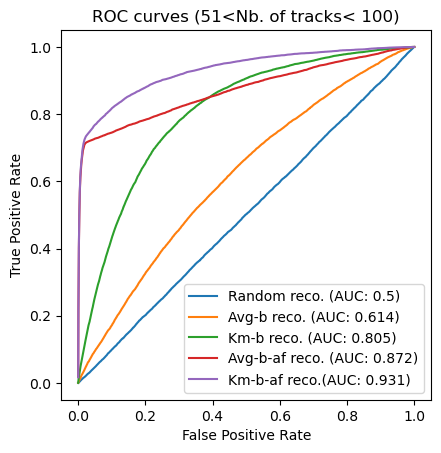

In [258]:
plt.plot(rand_fpr_avg, rand_tpr_avg, label = f'Random reco. (AUC: {round(rand_auc,3)})')
plt.plot(avg_fpr_avg, avg_tpr_avg, label = f'Avg-b reco. (AUC: {round(avg_auc,3)})')
plt.plot(kmbr_fpr_avg, kmbr_tpr_avg, label = f'Km-b reco. (AUC: {round(kmbr_auc,3)})')
plt.plot(avg_af_fpr_avg, avg_af_tpr_avg, label = f'Avg-b-af reco. (AUC: {round(avg_af_auc,3)})')
plt.plot(kmbr_af_fpr_avg, kmbr_af_tpr_avg, label = f'Km-b-af reco.(AUC: {round(kmbr_af_auc,3)})')


plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curves ({n_tracks_min}<Nb. of tracks< {n_tracks_max})")
plt.legend()
plt.savefig(FIG_PATH/f'modelisation/evaluation//{seed}/ROC_{n_tracks_min}_{n_tracks_max}.jpg')
plt.show()


## Work in progress

In [202]:

def kmeans_based_ranking(listenings_history, X,  weighted = False, n_clusters="Default",  random_state = None):  
    """
    Define the centroid(s) representing the average audio features of the tracks listened by a user.
    Estimate the affinity of the user for tracks that he didn't listened based on their distance with this (these) centroid(s).
    Return the rank of the unlistened tracks based on this afinity.
    
    Parameters:
        listening_history (pandas.Dataframe): a dataframe whose columns are
            - user : a unique id of the user
            
            - track_id : a unique id for a track
            
            - listening_count: the number of times the user has listened to the track
            
            ... : other columns corresponding to track's features and/or the user's features and/or element of context of the interaction user/track.
        
        X (pandas.Dataframe): a dataframe corresponding to the audio_features of the tracks.
        
        weighted (boolean, default = True): determines whether the centroid calculation is weighted by the listens number of the tracks.    
         
        n_clusters (int or 'auto'): define the number of centroids to form. If 'auto', it is determine as the arg max of the silhouette score.
        
        
        random_state (int, default=None): pass an int for reproducible output across multiple function calls.
        
    Return :
       R : the ranks of each tracks.
    """
    
    # Get the features of the songs listened by the user
    listenings_history_feats = X.loc[listenings_history.track_id]      
    
    
    _, _ , _, n_clust_opt =  get_listenings_history_partition(listenings_history_feats, listenings_history, random_state = random_state)
    # If a weighting of each tracks is desired :
    if weighted:
        # Calculation of the weight of each track according to its number of listens
        w = listenings_history.listening_count / listenings_history.listening_count.sum()
        w.index = listenings_history_feats.index 
        # Tracks weighting
        listenings_history_feats = listenings_history_feats.apply(lambda x: x*w)
    
    # Compute the user tracks centroids
    if n_clusters == 'auto':
        labels, centroids, _ ,n_clust_opt = get_listenings_history_partition(listenings_history_feats, listenings_history, random_state = random_state)
    elif n_clusters == 1:
        labels = np.zeros(len(listenings_history))
        centroids = np.array(listenings_history_feats.apply('mean'), ndmin = 2)
    elif n_clusters == 'Default':
        clf = KMeans(n_clusters = n_clust_opt, n_init = 'auto', random_state = random_state)
        clf.fit(listenings_history_feats, sample_weight=listenings_history.listening_count)
        centroids = clf.cluster_centers_
        labels = clf.labels_
    
    # Define the number of neighbors to find according to the clusters size
    # cluster_size = pd.Series(labels).value_counts()
    # nb_tracks_by_clusters = [round(n_neighbors * v) for v in cluster_size / sum(cluster_size)]
    # if not sum(nb_tracks_by_clusters) == n_neighbors:
    #     nb_tracks_by_clusters[-1] = n_neighbors - sum(nb_tracks_by_clusters[:-1])
        
    # Compute the distnce between the tracks and the centroids  
    D = pd.DataFrame(distance_matrix(X.loc[X.index.difference(listenings_history_feats.index)], centroids), index = X.index.difference(listenings_history_feats.index))           

#     # Get the ranks of the tracks relating to its distance with each centroid
    R = D.rank(axis = 0)

#     # Get the n_neighbors unique recommended tracks
#     recommended_tracks = []
#     for i, n in enumerate(nb_tracks_by_clusters):
#         tracks = [t for t in list(R.iloc[:,i].sort_values().index) if not t in recommended_tracks]
#         recommended_tracks = recommended_tracks + tracks[:n]

    return R


In [201]:
def rank_by_artist_filter(initial_ranking, apparent_history: pd.DataFrame):
    
    initial_ranking.insert(0, 'artist_name', initial_ranking['track_id'].str.split(' - ').str[1])
    initial_ranking['min_centroids'] =  np.nan
    initial_ranking['artist_rank'] =  np.nan
    # get the artists and sort them by proportion in df_user_apparent  
    user_artists = (apparent_history.groupby('artist_name')['track_id'].count()/len(apparent_history)).sort_values(ascending=False)


    # create a blank df with same columns as user_rank
    # calculate the minimum between centroids for each track of artists identified in df_user_apparent
    # sort them by this minimum distance
    # attribute them a new rank from 1 to len(track_ids) of each artist identifies in order of their importance in df_user_apparent 
    user_rank_artist = initial_ranking.drop(index = initial_ranking.index, axis=0)
    for i, artist in enumerate(user_artists.index):
        user_temp = initial_ranking[initial_ranking['artist_name'] == user_artists.index[i]]
        user_temp['min_centroids'] = user_temp.iloc[:, 2:-2].min(axis=1)
        user_temp = user_temp.sort_values(by='min_centroids')
        user_temp['artist_rank'] = user_temp['min_centroids'].rank(method = 'first', ascending=True) + len(user_rank_artist)
        user_rank_artist = pd.concat([user_rank_artist,user_temp])


    # in original ranking, drop tracks already reranked by artist frequency for artists identified in df_user_apparent
    initial_ranking = initial_ranking.drop(user_rank_artist.index)

    # sort values of initial ranking by minimum found for each centroid
    initial_ranking['min_centroids'] = initial_ranking.iloc[:,2:-2].min(axis=1)
    initial_ranking = initial_ranking.sort_values(by='min_centroids')
    # attribute them new ranks based on the length of user_rank_artist to get a single rank by track/artist
    initial_ranking['artist_rank'] = initial_ranking['min_centroids'].rank(method='first') + len(user_rank_artist)   

    # combine new ranking based on artists identified and initial ranks reranked as a continuity of artist based ranks
    full_ranks = pd.concat([user_rank_artist, initial_ranking])
    full_ranks['best_rank'] = full_ranks.iloc[:, -2:].min(axis=1)
    full_ranks.index = full_ranks.track_id
    
    return full_ranks